In [1]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('./data/sksolartimevariation5804d.txt', skiprows=13, sep='\s+', names=['t_mean(s)', 't_mean-t_start(s)', 't_end-t_mean(s)', 'nu_flux(1e6cm-2s-1)', 'flux_up_error(1e6cm-2s-1)', 'flux_down_error(1e6cm-2s-1)'])
data

,t_mean(s),t_mean-t_start(s),t_end-t_mean(s),nu_flux(1e6cm-2s-1),flux_up_error(1e6cm-2s-1),flux_down_error(1e6cm-2s-1)
0,833654760,170100,277380,2.74,0.63,0.53
1,834127080,175500,210060,2.83,0.75,0.62
2,834550800,213180,230160,2.30,0.53,0.45
3,834997020,199380,212640,1.79,0.55,0.44
4,835380420,170520,265680,3.15,0.74,0.61
...,...,...,...,...,...,...
1338,1525315550,172739,172774,2.36,0.36,0.33
1339,1525703838,215064,215054,2.26,0.31,0.29
1340,1526138206,216970,216028,1.88,0.33,0.29
1341,1526588224,232102,226109,1.90,0.38,0.28


date_to_calculate = "2024-02-14"
observer_location = EarthLocation(lat=-90*un.deg, lon=0*un.deg, height=0*un.m)

observation_time = time.Time(date_to_calculate)
with solar_system_ephemeris.set('builtin'):
    sun_position = get_sun(observation_time)

sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

distance = sun_altaz.distance
print(distance)


Still can you divide each bin into about 5 sub-bins \
and calculate the distance in each bin and take the average\

If they are almost the same,then just calculate the distance at the mod-point\
In the end the goal is to multiply the flux provided by this distance**2\



In [2]:
def calculate_distance(date):
    # Set the observer's location on Earth (you can change these coordinates as needed)
    observer_location = EarthLocation(lat=0*un.deg, lon=0*un.deg, height=0*un.m)

    # Set the date for which you want to calculate the distance
    observation_time = time.Time(date)

    # Get the position of the Sun at the specified date
    with solar_system_ephemeris.set('builtin'):
        sun_position = get_sun(observation_time)

    # Transform the Sun's position to Altitude-Azimuth coordinates
    sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

    # Calculate the distance between the Sun and the Earth
    distance = sun_altaz.distance

    return distance

In [3]:
#convert time elapsed (in seconds) since 1st jan 1970 to dd/mm/yyyy format python

def convert_time_to_date(time_elapsed):
    return time.Time(time_elapsed, format='unix').to_datetime()


In [4]:
arara = convert_time_to_date(data['t_mean(s)'].values[-1])

In [5]:
calculate_distance(arara.strftime("%Y-%m-%d"))

<Distance 1.01224756 AU>

In [6]:
avg_dists_2 = []
t_mean_days = []
for i in range(len(data)):
    row = data.iloc[i]
    t_start = row['t_mean(s)'] - row['t_mean-t_start(s)']
    t_end = row['t_mean(s)'] + row['t_end-t_mean(s)']
    t_mean_days.append(convert_time_to_date(row['t_mean(s)']).strftime("%Y-%m-%d"))
    T_bins = np.linspace(t_start, t_end, 6)
    T_bins = convert_time_to_date(T_bins)
    T_bins = np.array([x.strftime("%Y-%m-%d") for x in T_bins])
    # print(T_bins)
    # dists = [calculate_distance(x) for x in T_bins]
    dists = calculate_distance(T_bins)
    # avg_dist = np.mean(dists)
    avg_dists_2.append(dists.mean().value**2)
    # print(dists)
    

In [7]:
times = data['t_mean(s)'].values * un.s
flux = data['nu_flux(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_up_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_down_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6

In [8]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

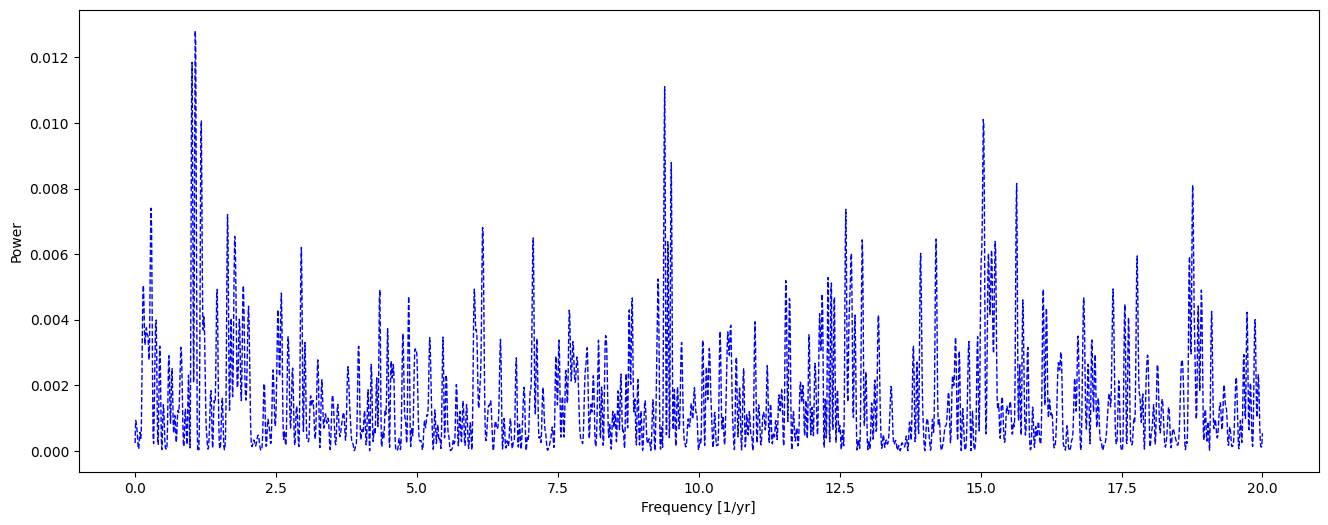

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(freq, power, '--', lw=1, c='b')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.show()

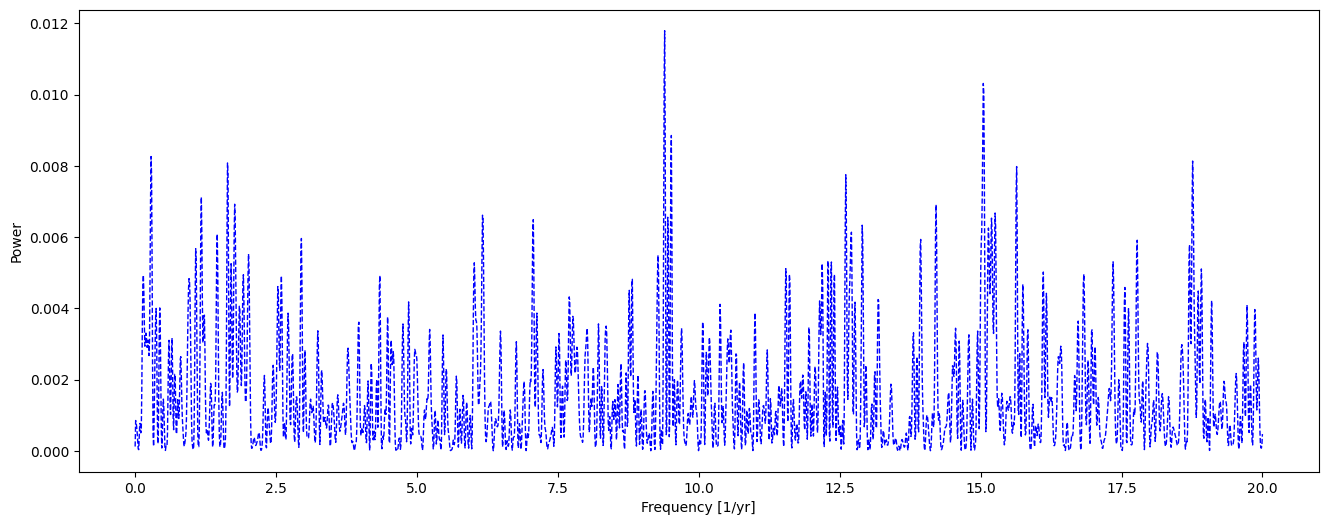

In [10]:
lsp_d2 = LombScargle(times, np.multiply(flux, avg_dists_2), dy=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), normalization='log')
freq_d2, power_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

plt.figure(figsize=(16, 6))
plt.plot(freq_d2, power_d2, '--', lw=1, c='b')
plt.xlabel('Frequency [1/yr]')
plt.ylabel('Power')
plt.show()

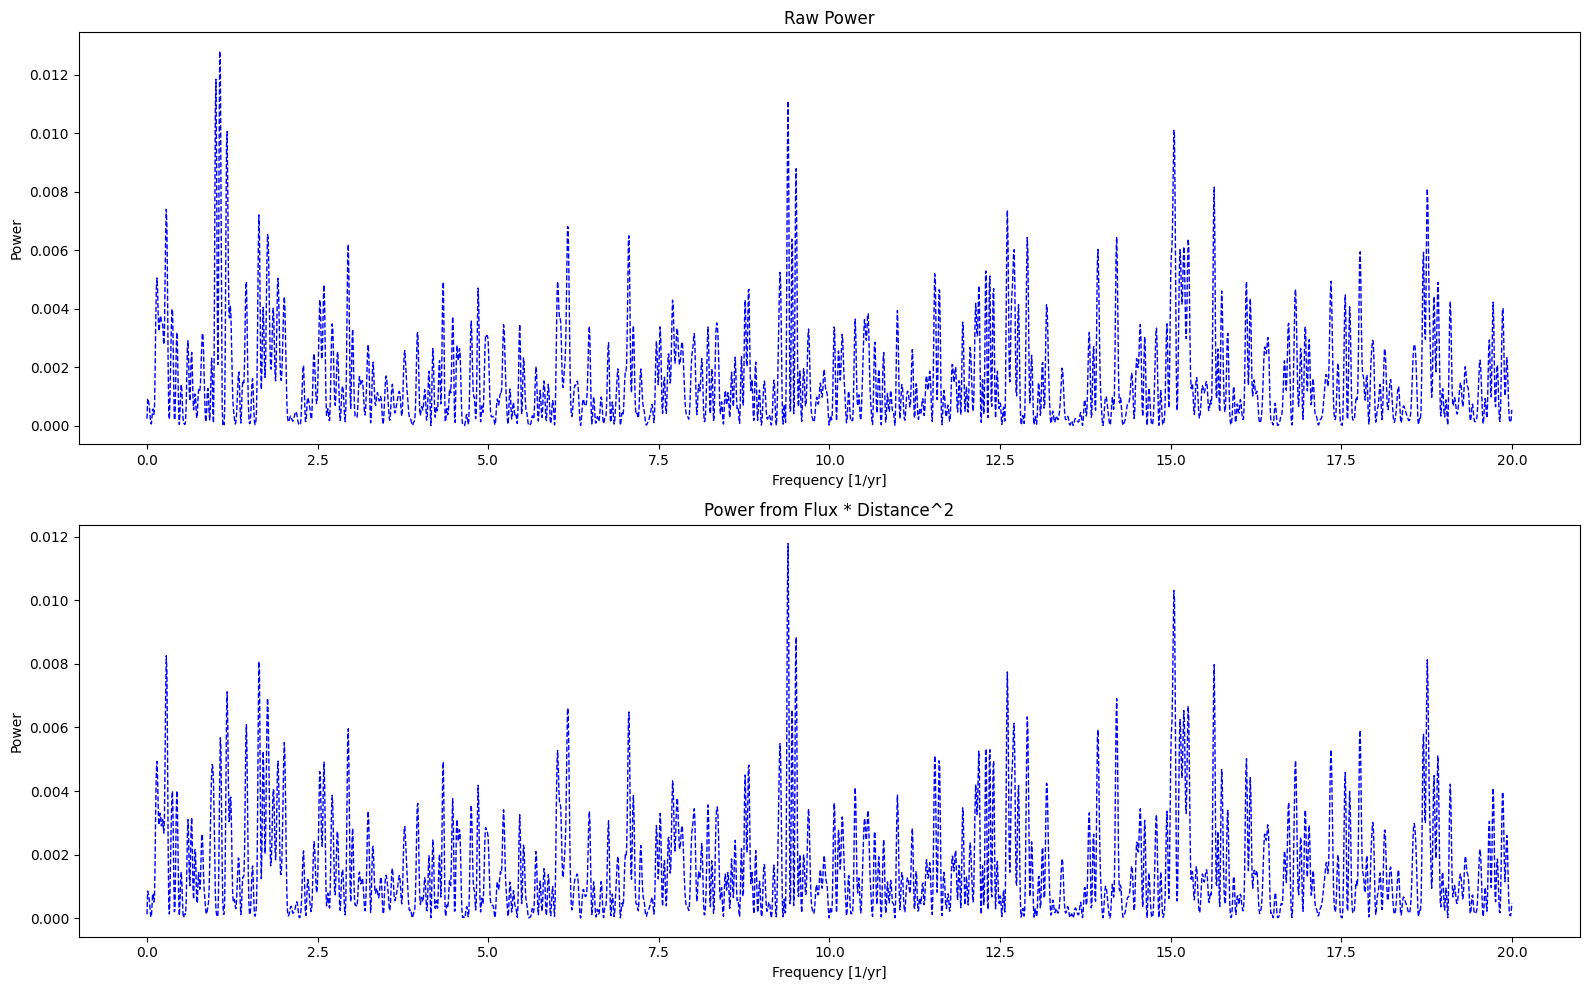

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq, power, '--', lw=1, c='b')
ax[0].set_title('Raw Power')
ax[1].plot(freq_d2, power_d2, '--', lw=1, c='b')
ax[1].set_title('Power from Flux * Distance^2')
for i in range(2):
    ax[i].set_xlabel('Frequency [1/yr]')
    ax[i].set_ylabel('Power')
plt.tight_layout()
plt.show()

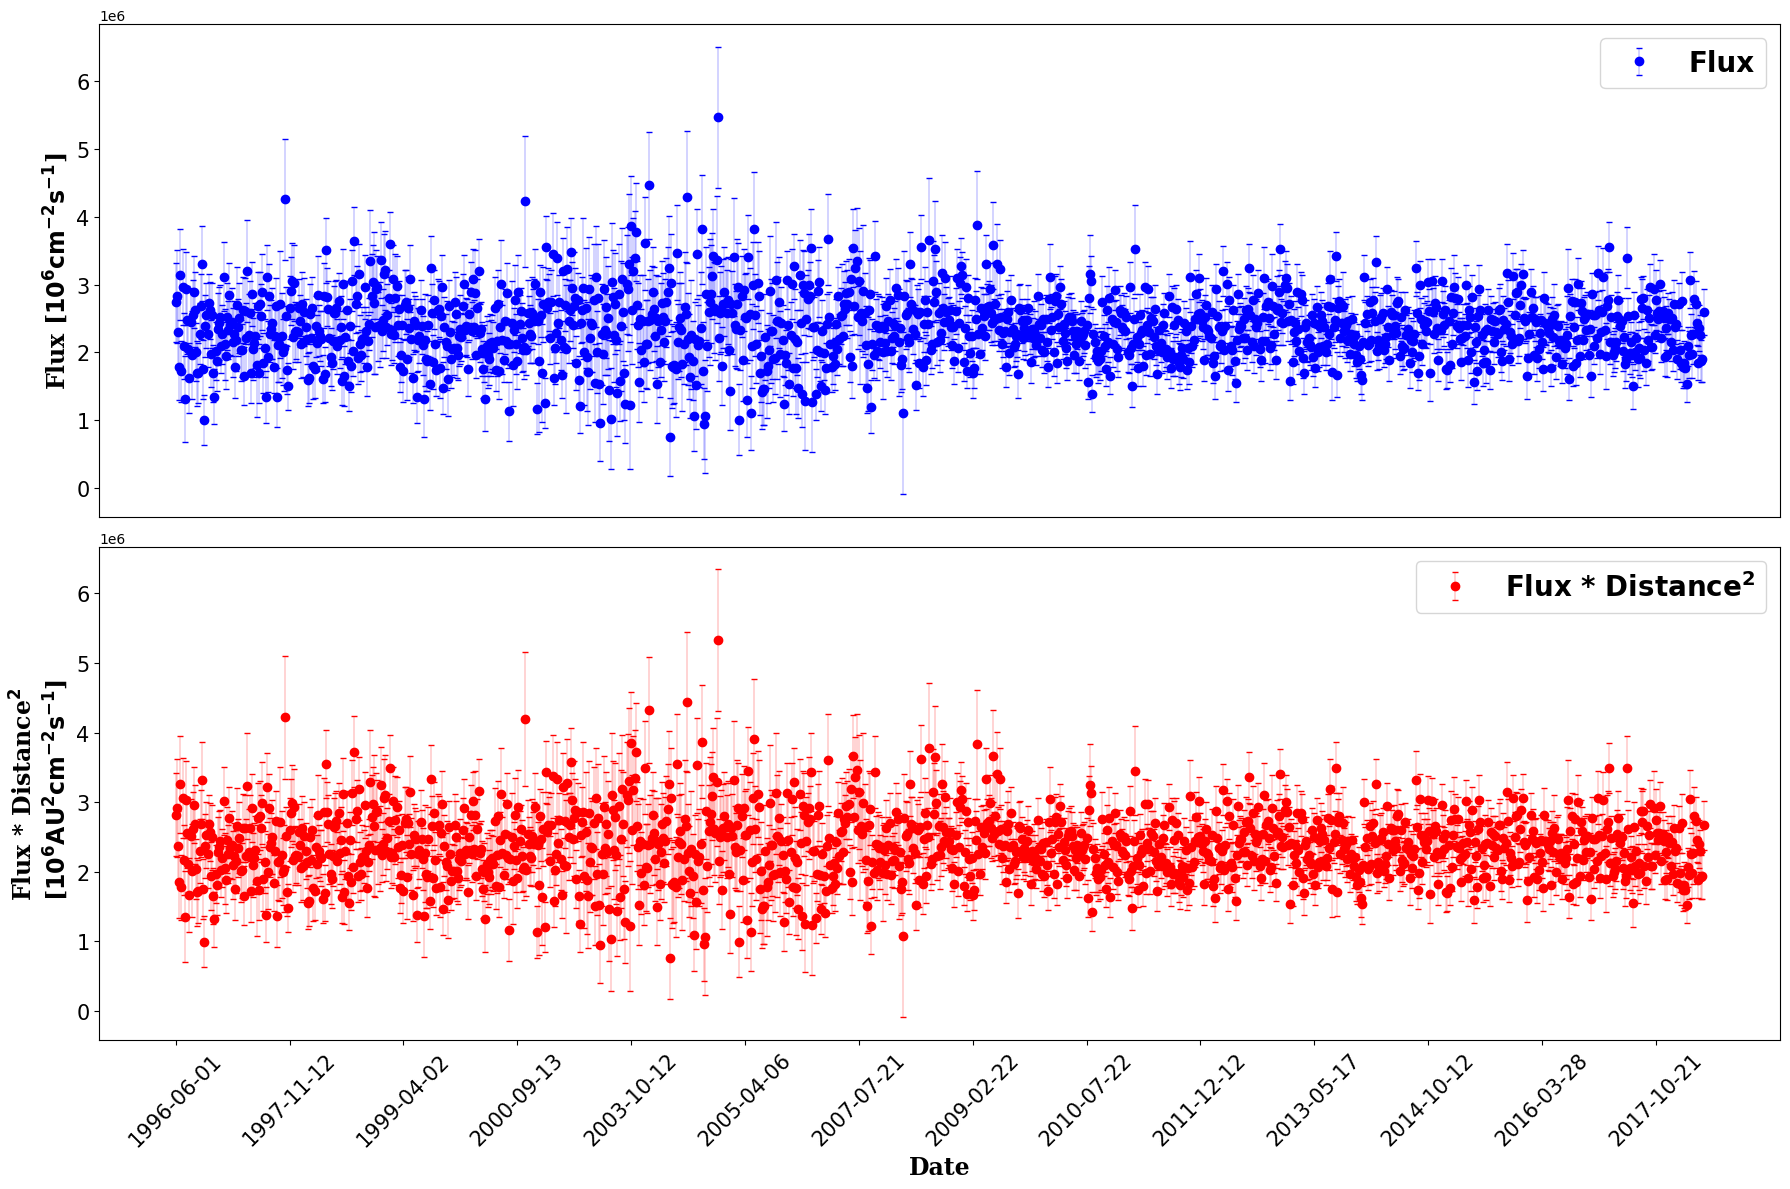

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

ax[0].errorbar(t_mean_days, flux, yerr=0.5*(flux_err_up+flux_err_down), fmt='o', c='b', elinewidth=0.24, capsize=2, label='Flux')
ax[1].errorbar(t_mean_days, np.multiply(flux, avg_dists_2), yerr=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), fmt='o', c='r', elinewidth=0.24, capsize=2, label='Flux * Distance$\mathbf{^2}$')

ax[0].set_ylabel('Flux [$\mathbf{10^6 cm^{-2} s^{-1}}$]', fontdict=axesfont)


ax[1].set_ylabel('Flux * Distance$\mathbf{^2}$\n [$\mathbf{10^6 AU^{2} cm^{-2} s^{-1}}$]', fontdict=axesfont)

for i in range(2):
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':20, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Date',  fontdict=axesfont)
ax[1].set_xticks(t_mean_days[::100])
ax[1].xaxis.set_tick_params(labelsize=15, rotation=45)
plt.tight_layout()
plt.savefig('./outputs/timeseries.pdf')
plt.show()